In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import choroplethNYC as cp
import geopandas as gpd
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
import fiona
from geopandas import GeoDataFrame
import shapely
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Task 1 - Prep the data

In [2]:
# Download the Census data and NYC zipcode shapefile

# !for ((y=94; y<=99; y+=1)); do wget \
# https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp$y\totals.zip; done

# !for ((y=0; y<=1; y+=1)); do wget \
# https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV//zbp0$y\totals.zip; done

# !for ((y=2; y<=9; y+=1)); do wget \
# https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

# !for ((y=10; y<=14; y+=1)); do wget \
# https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

#!wget "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
#!unzip "zbp14totals.zip"

# MAKE A CELL SHOWING HOW YOU UNZIPPED THE DATA

In [3]:
# Import the relevant colums from the data

yearsLower1 = ['zbp94totals.txt', 'zbp95totals.txt', 'zbp96totals.txt', 'zbp97totals.txt']

yearsUpper = ['zbp98totals.txt', 'zbp99totals.txt', 'zbp00totals.txt', 'zbp01totals.txt', 'zbp02totals.txt']

yearsLower2 = ['zbp03totals.txt','zbp04totals.txt', 'zbp05totals.txt', 'zbp06totals.txt',
               'zbp07totals.txt', 'zbp08totals.txt','zbp09totals.txt', 'zbp10totals.txt',
               'zbp11totals.txt', 'zbp12totals.txt', 'zbp13totals.txt','zbp14totals.txt']

dfList = []
count1 = 1994
count2 = 1998
count3 = 2003

for i in yearsLower1:
    df = pd.read_csv(i)
    df = df[['zip', 'est']]
    df = df.rename(columns={'est': count1})
    dfList.append(df)
    count1 +=1
    
for i in yearsUpper:    
    df = pd.read_csv(i)
    df = df[['ZIP', 'EST']]
    df = df.rename(columns={'ZIP': 'zip', 'EST': count2})
    dfList.append(df)
    count2 +=1
    
for i in yearsLower2:
    df = pd.read_csv(i)
    df = df[['zip', 'est']]
    df = df.rename(columns={'est': count3})
    dfList.append(df)
    count3 +=1

In [4]:
# Import and clean up the NYC Zipcode shapefile

nycZip = gpd.GeoDataFrame.from_file("ZIP_CODE_040114.shp")
nycZip = nycZip.drop(['BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 
                      'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1, inplace=False)
nycZip = nycZip.rename(columns={'ZIPCODE': 'zip'})
nycZip['zip'] = nycZip['zip'].astype(int)

In [5]:
# Merging the dataframes together 

dfNYC = pd.merge(nycZip, dfList[0], on='zip', how='inner')

for i in range(1,21):
    dfNYC = pd.merge(dfNYC, dfList[i], on='zip', how='inner')

In [20]:
dfNYC.head()

,zip,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,50,53,51,51,58,65,57,...,82,80,84,90,92,98,101,95,99,109
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,420,433,456,476,473,477,493,...,556,565,556,592,621,675,674,726,755,772
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,494,502,527,519,541,520,527,...,587,570,587,602,647,699,713,721,731,752
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,387,388,410,416,409,417,422,...,491,499,514,520,543,580,597,623,673,696
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,1015,1049,1075,1118,1149,1161,1180,...,1332,1331,1377,1397,1457,1474,1523,1605,1687,1736


In [7]:
# Normalize the rows

# Make a copy 
NYCtimeSeries = pd.DataFrame(dfNYC)
NYCtimeSeries = NYCtimeSeries.drop(['geometry', 'zip'],axis=1, inplace=False)

# Subtract mean
NYCsubtract = NYCtimeSeries.sub(NYCtimeSeries.mean(axis=1), axis=0)

# Divide by standard deviation
NYCnormal = NYCsubtract.divide(NYCtimeSeries.std(axis=1), axis=0)
NYCnormal.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
1,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
2,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
3,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
4,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


In [8]:
# Adding zipcode and geometry 
data = pd.concat([dfNYC, NYCnormal], axis=1)

# Converting back to geodataframe
crs = {'init': 'epsg:4326'}
gdf_data = GeoDataFrame(data, crs=crs, geometry='geometry')
gdf_data.head()

,zip,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,50,53,51,51,58,65,57,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,420,433,456,476,473,477,493,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,494,502,527,519,541,520,527,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,387,388,410,416,409,417,422,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,1015,1049,1075,1118,1149,1161,1180,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


# Task 2 - Cluster the establishments with K-Means

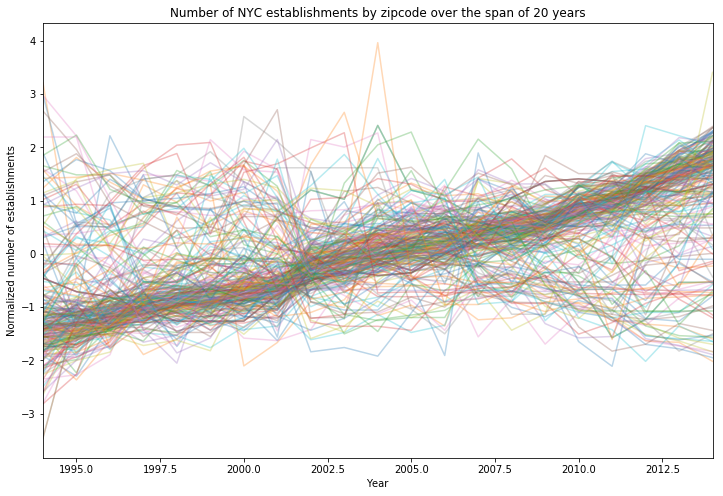

In [9]:
# Plot the time series for the sake of visualization

NYCnormal.T.plot(use_index=True, figsize=(12,8), legend=False, alpha=(.3));
pl.title("Number of NYC establishments by zipcode over the span of 20 years")
pl.ylabel("Normalized number of establishments")
pl.xlabel("Year");

### Figure 1 is a visualization of the normalized number of establishments per zipcode over the span of 20 years (1994 to 2014). The goal is to cluster these datapoints into fewer, identifiable trends.

In [10]:
# K Means Clustering

nc = 6

km = KMeans(n_clusters=nc)

km.fit(NYCnormal)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Task 3 - Plotting the K-Means cluster centers


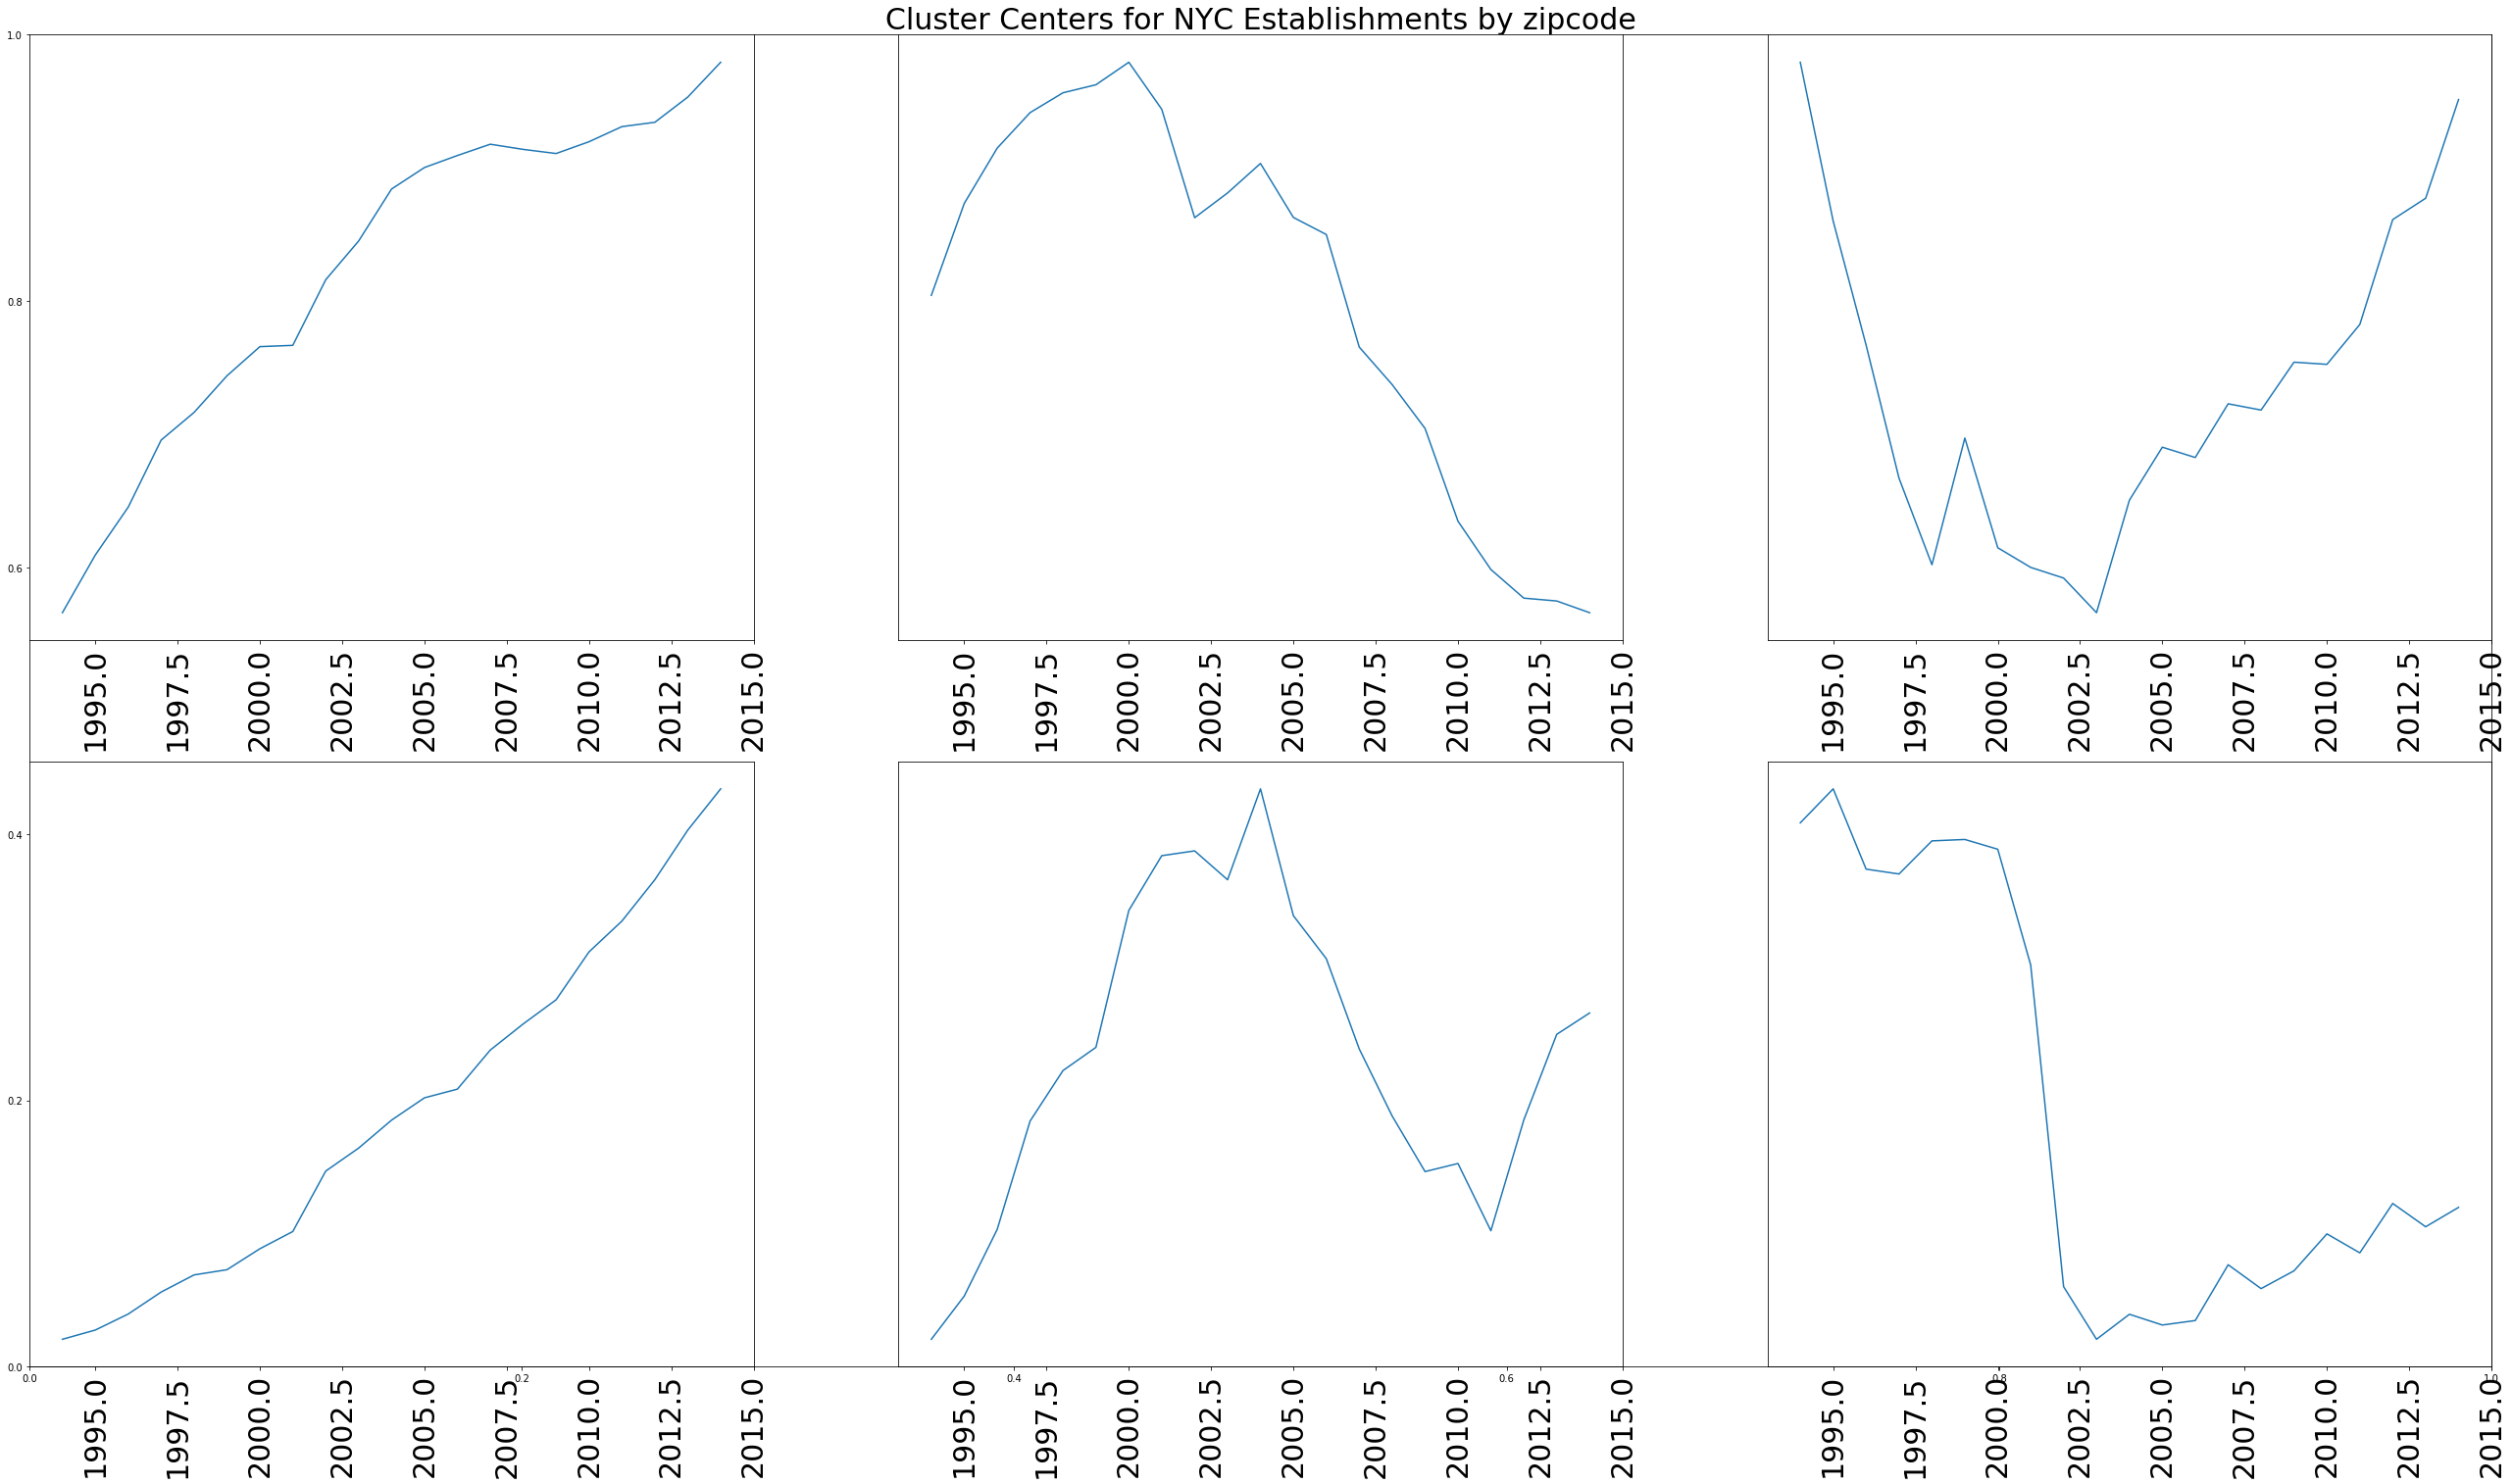

In [11]:
# Plotting the K Means cluster centers independently

fig = pl.figure(figsize=(45,25))
pl.title("Cluster Centers for NYC Establishments by zipcode", fontsize=30)
rng = [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
      2009, 2010, 2011, 2012, 2013, 2014]

for i,cc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(rng, cc)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(30) 
        tick.label.set_rotation('vertical')

### Figure 2 shows the 6 cluster centers independently plotted

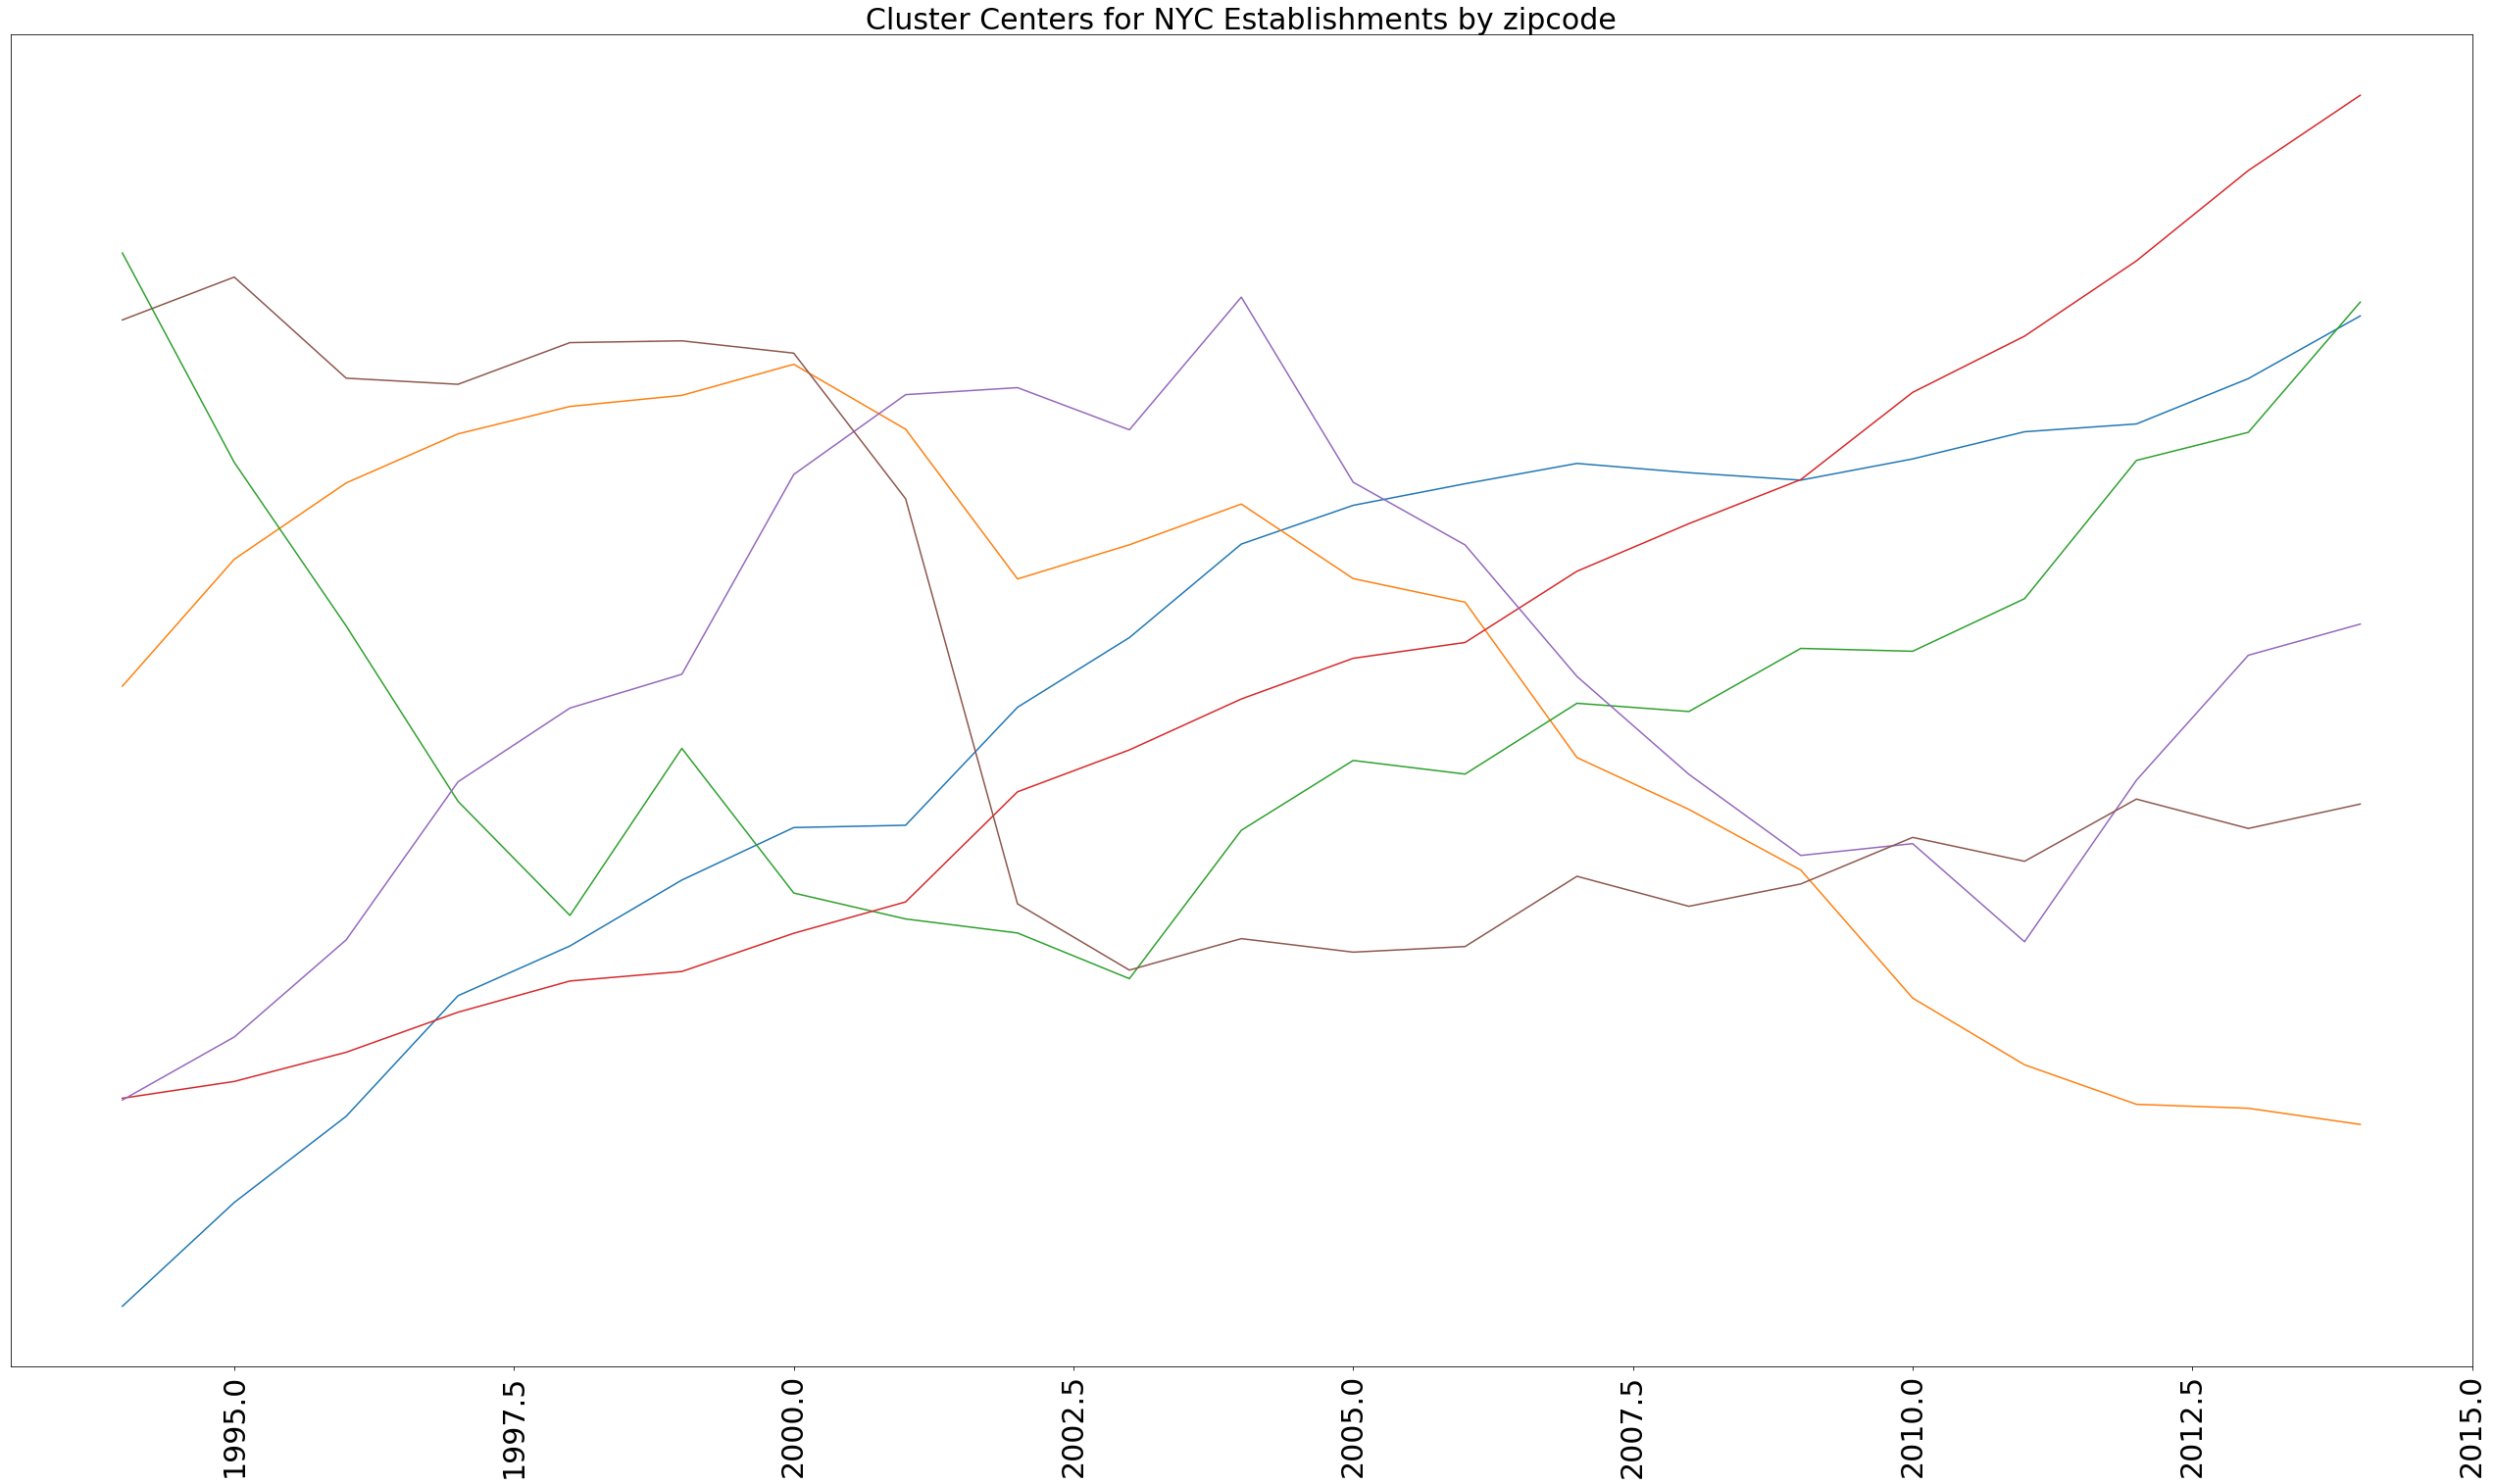

In [12]:
# Plot the K Means cluster centers together

fig = pl.figure(figsize=(45,25))
ax = fig.add_subplot(1,1,1)
ax.set_yticks([])

pl.title("Cluster Centers for NYC Establishments by zipcode", fontsize=30)
rng = [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
      2009, 2010, 2011, 2012, 2013, 2014]

for i,cc in enumerate(km.cluster_centers_):
    ax.plot(rng, cc)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(30) 
        tick.label.set_rotation('vertical')

### Figure 3 shows the 6 cluster centers mapped in one plot. Comparing the visualization to Figure 1, we can see that the general trends are in tact. 

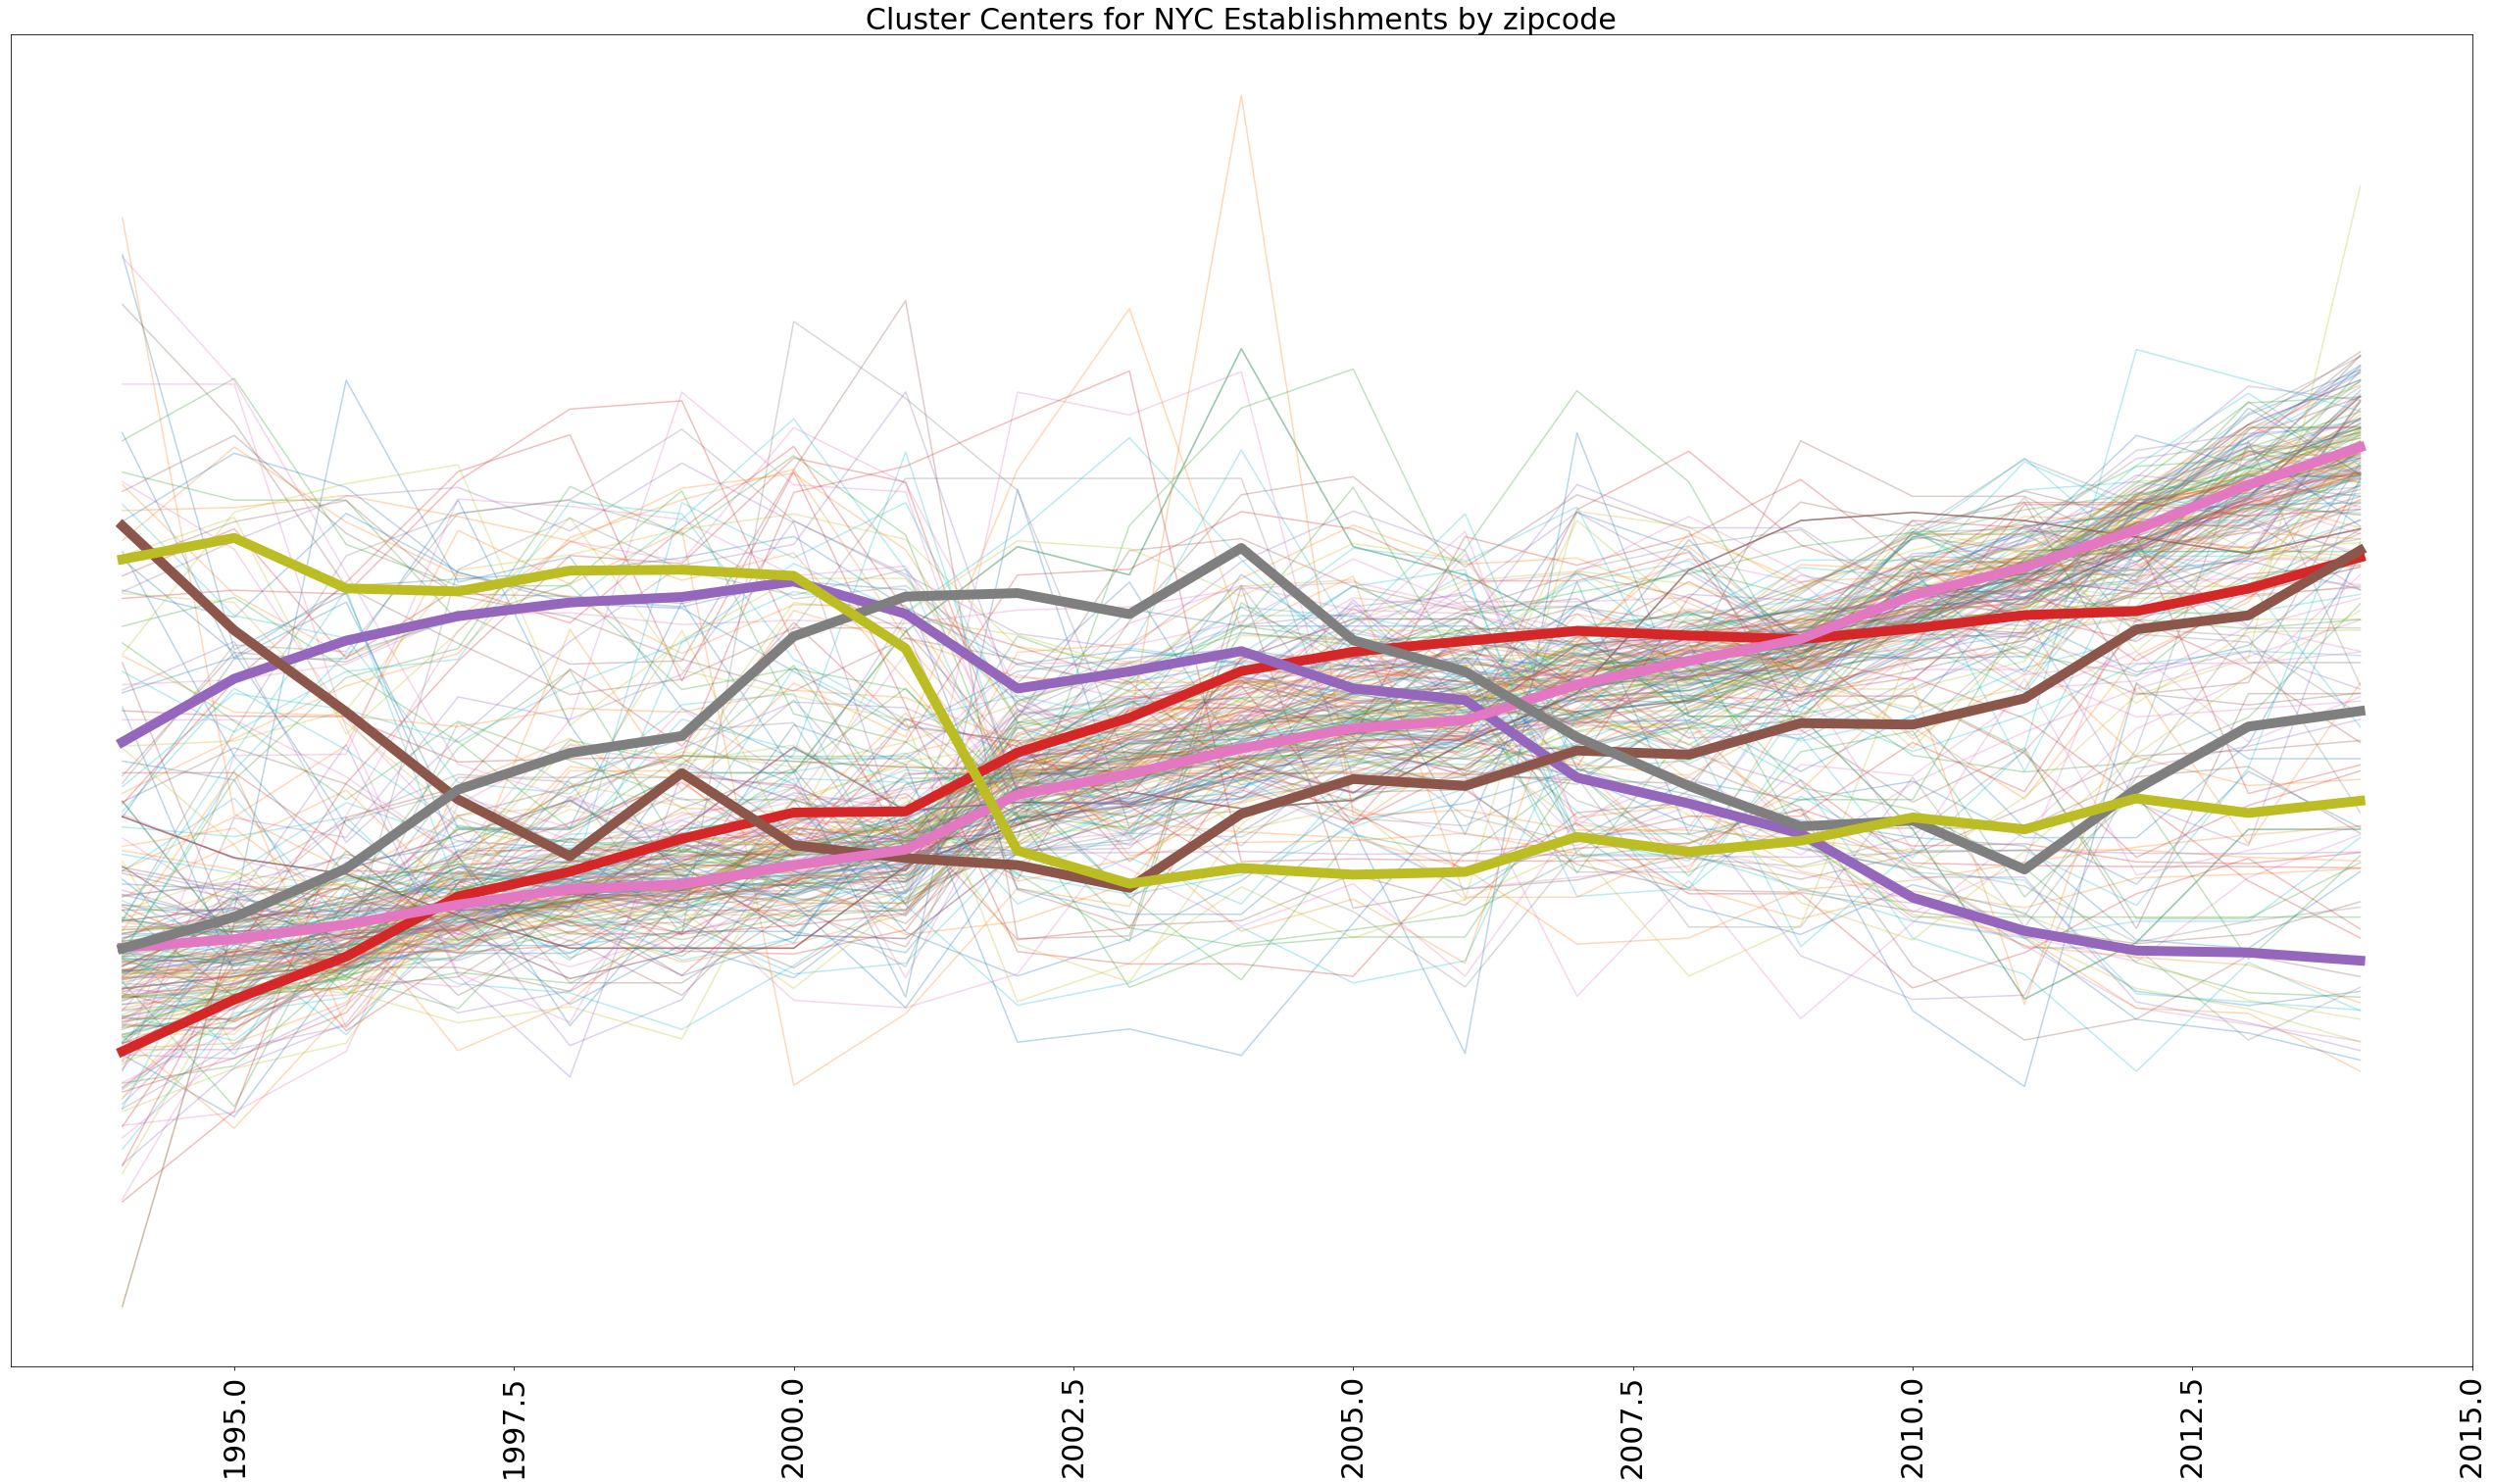

In [13]:
# Plot the K Means cluster centers atop the individual time series

fig = pl.figure(figsize=(45,25))
ax = fig.add_subplot(1,1,1)
ax.set_yticks([])

pl.title("Cluster Centers for NYC Establishments by zipcode", fontsize=30)
rng = [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
      2009, 2010, 2011, 2012, 2013, 2014]

for i in range(len(NYCnormal)):
    ax.plot(rng, NYCnormal.iloc[i], alpha=.3)

for i,cc in enumerate(km.cluster_centers_):
    ax.plot(rng, cc, linewidth=10)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(30) 
        tick.label.set_rotation('vertical')

### Figure 4 maps the cluster centers atop the initial visualization from Figure 1.


# Task 4 - Clustering using the Gaussian Mixture Method

In [17]:
# Adding KM cluster numbers to dataframe

kmlabels = km.fit_predict(NYCnormal)
gdf_data['KMClusterNumbers'] = kmlabels

# Adding GM cluster numbers to dataframe

GMcluster = GMM(n_components = 6)
GMlabels = GMcluster.fit_predict(NYCnormal)
gdf_data['GMClusterNumbers'] = GMlabels

gdf_data.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/rh/anacond

,zip,geometry,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,KMClusterNumbers,GMClusterNumbers
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",51,50,53,51,51,58,65,57,...,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,0,0
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",406,420,433,456,476,473,477,493,...,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,0,0
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",505,494,502,527,519,541,520,527,...,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,0,0
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",381,387,388,410,416,409,417,422,...,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,0,0
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",985,1015,1049,1075,1118,1149,1161,1180,...,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,0,0


# Task 5 - Plot choropleth of both clustering methods 

In [18]:
# List the number of zipcodes in each cluster for both methods

print('K-Means Clusters')
for cluster in set(gdf_data['KMClusterNumbers']):
    print ('There are ', sum(gdf_data['KMClusterNumbers'] == cluster), "zip codes included in KM cluster", cluster)

print('\nGaussian Mixture Clusters')
for cluster in set(gdf_data['GMClusterNumbers']):
    print ('There are ', sum(gdf_data['GMClusterNumbers'] == cluster), "zip codes included in GM cluster", cluster)

K-Means Clusters
('There are ', 140, 'zip codes included in KM cluster', 0)
('There are ', 21, 'zip codes included in KM cluster', 1)
('There are ', 15, 'zip codes included in KM cluster', 2)
('There are ', 14, 'zip codes included in KM cluster', 3)
('There are ', 14, 'zip codes included in KM cluster', 4)
('There are ', 39, 'zip codes included in KM cluster', 5)

Gaussian Mixture Clusters
('There are ', 109, 'zip codes included in GM cluster', 0)
('There are ', 10, 'zip codes included in GM cluster', 1)
('There are ', 37, 'zip codes included in GM cluster', 2)
('There are ', 44, 'zip codes included in GM cluster', 3)
('There are ', 22, 'zip codes included in GM cluster', 4)
('There are ', 21, 'zip codes included in GM cluster', 5)


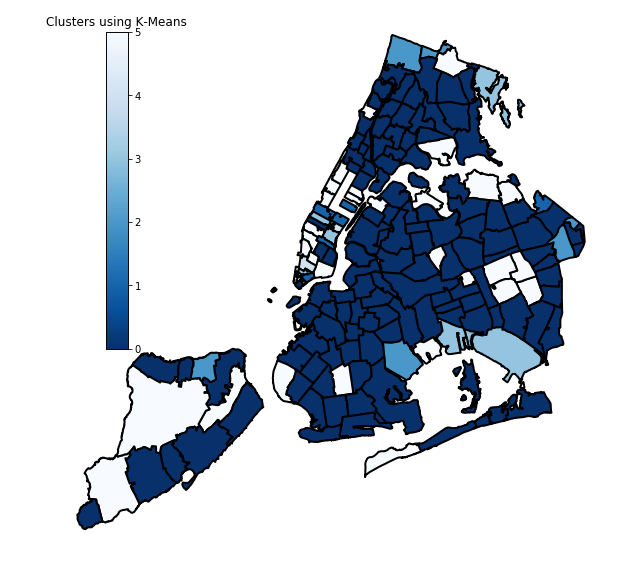

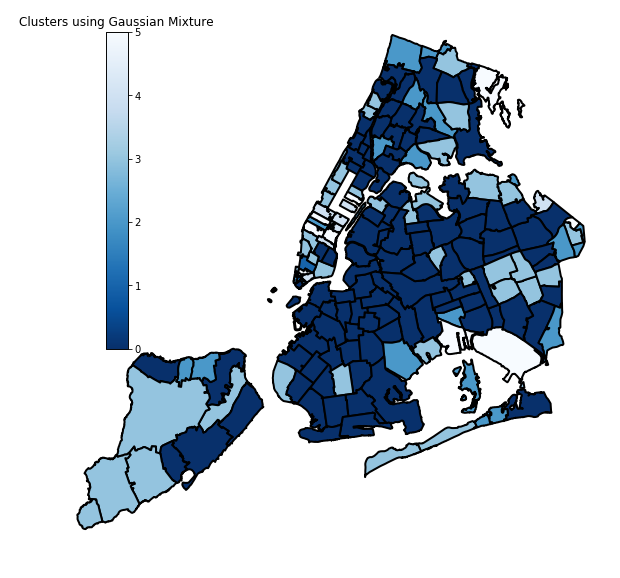

In [19]:
# Plot the KMeans clusters

cp.choroplethNYC(gdf_data, column='KMClusterNumbers', color="white", edgecolor="black", cmap='Blues_r',lw=2)
pl.title("Clusters using K-Means")

# Plot the GM clusters

cp.choroplethNYC(gdf_data, column='GMClusterNumbers', color="white", edgecolor="black", cmap='Blues_r', lw=2)
pl.title("Clusters using Gaussian Mixture");

### Figure 5 consists of two chloropleths. The first choropleth represents the clusters using the K-Means method, and the second choropleth represents the clusters using the Gaussian Mixture method. 

# Tasks 6 & 7 - Compare the results and interpret them

### Both methods reveal a relatively large cluster spanning parts of Brooklyn, Queens, Staten Island, and the Bronx. The Gaussian Mixture method seems to reveal a bit more granularity, especially in the Bronx. 

### The large cluster visible in both choropleths could represent areas that are zoned for mixed usage (residential and business). Using my knowledge of Staten Island, the further south you go, the fewer establishments you find; those regions are highly residential, whereas the north shore and eastern coast (along Hylan Blvd and Fr. Capodanno) have higher concentrations of businesses mixed throughout the residential areas. Regions in Downtown Manhattan belong to a variety of clusters, which could be due to how condenced the regions are and how many businesses are vertically stacked in high-rise buildings in this area (assuming, of course, that individual offices are counting toward the establishment count). 